In [3]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from functools import partial

warnings.filterwarnings(action = "ignore")

In [15]:
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
full_features = iris_data.data 

In [5]:
from sklearn.datasets import load_iris
from prepare_utils import data_preprocess

dataset = load_iris
X_train, X_test, y_train, y_test, num_features = data_preprocess(dataset)

load_iris preprocessed


In [7]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Initialize feature map
feature_map = ZZFeatureMap(feature_dimension = num_features,
                           reps = 1,
                           entanglement = "linear")

# Define the sampler
sampler = Sampler()

# Compute fidelities
fidelity = ComputeUncompute(sampler=sampler)

# Create a quantum kernel
kernel = FidelityQuantumKernel(fidelity=fidelity,
                               feature_map=feature_map)

In [11]:
from qiskit_machine_learning.algorithms import QSVC

qsvc_full = QSVC(quantum_kernel=kernel, probability=True)

qsvc_full.fit(X_train, y_train)

qsvc_score = qsvc_full.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


In [12]:
from evaluation_utils import generate_classification_report

generate_classification_report(qsvc_full, X_test, y_test, model_name="QSVC")

,precision,recall,f1-score,support,Model
0,1.0,1.0,1.0,10.0,QSVC
1,1.0,1.0,1.0,10.0,QSVC
2,1.0,1.0,1.0,10.0,QSVC
accuracy,1.0,1.0,1.0,1.0,QSVC
macro avg,1.0,1.0,1.0,30.0,QSVC
weighted avg,1.0,1.0,1.0,30.0,QSVC


In [17]:
qsvc_scores = {}
training_times = {}

data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

for i, description in enumerate(data_descriptions):

    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i - 1, axis = 1)

    num_features = adjusted_features.shape[1]
    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    X_train_subs, X_test_subs, y_train_subs, y_test_subs = train_test_split(
        adjusted_features, labels,
        train_size = 0.8, random_state = algorithm_globals.random_seed,
        stratify = labels
    )
    feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 1,
                              entanglement = "linear")
    kernel = FidelityQuantumKernel(
        fidelity = fidelity,
        feature_map = feature_map
    )
    qsvc = QSVC(quantum_kernel = kernel)

    start_time = time.time()
    qsvc.fit(X_train_subs, y_train_subs)
    elapsed_time = time.time() - start_time
    training_times[description] = elapsed_time

    # Evaluate model performance
    qsvc_score = qsvc.score(X_test_subs, y_test_subs)
    qsvc_scores[description] = qsvc_score
    
    print(f"{description} - QSVC classification test score: {qsvc_score}, Training time: {elapsed_time:.2f} seconds")

Full Features - QSVC classification test score: 1.0, Training time: 24.45 seconds
Missing Sepal Length - QSVC classification test score: 1.0, Training time: 18.69 seconds
Missing Sepal Width - QSVC classification test score: 1.0, Training time: 17.65 seconds
Missing Petal Length - QSVC classification test score: 0.9666666666666667, Training time: 17.59 seconds
Missing Petal Width - QSVC classification test score: 0.9666666666666667, Training time: 16.79 seconds


In [19]:
df = pd.DataFrame(list(qsvc_scores.items()), columns=['Description', 'Test Score'])
df

,Description,Test Score
0,Full Features,1.000000
1,Missing Sepal Length,1.000000
2,Missing Sepal Width,1.000000
3,Missing Petal Length,0.966667
4,Missing Petal Width,0.966667


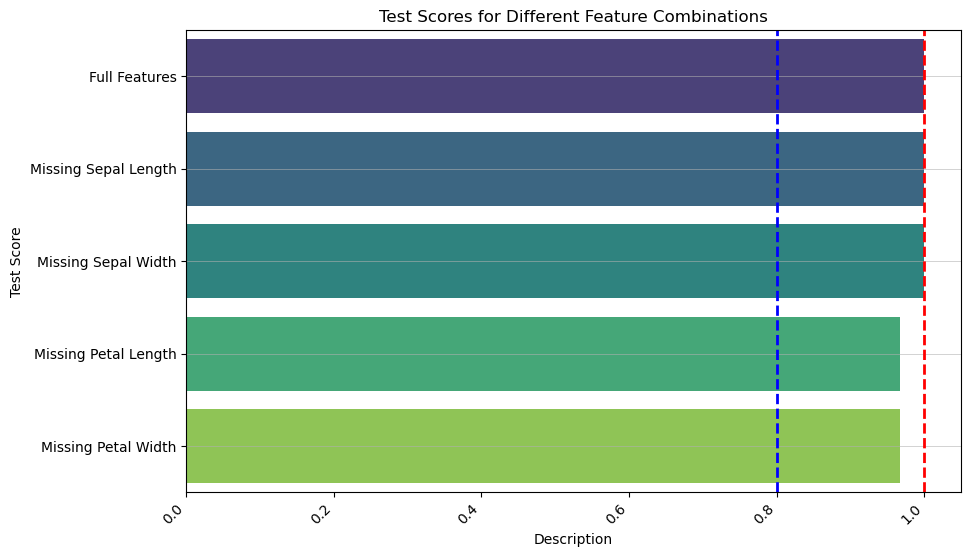

In [26]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

sns.barplot(y='Description', x='Test Score', data=df, palette='viridis')
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=0.8, color='blue', linestyle='--', linewidth=2)

plt.title('Test Scores for Different Feature Combinations')
plt.xlabel('Description')
plt.ylabel('Test Score')

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linewidth=0.4)
plt.show()

In [28]:
#qsvc_full.save('quantum_classifiers/qsvc-zzfeaturemap-linear.model')